In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import matplotlib.dates as mdates
import os
import geopandas as gpd
import matplotlib
from datetime import datetime

In [2]:
# # social determinants of health
sdoh_df = pd.read_excel("./data/SDOH_2020_COUNTY_1_0.xlsx", sheet_name="Data")

# unemployment rate dataset
unemp_df = pd.read_excel(
    "./data/Unemployment.xlsx",
    sheet_name="UnemploymentMedianIncome",
    skiprows=[0, 1, 2, 3],
    header=None,
)
unemp_df = pd.DataFrame(unemp_df.values[1:], columns=unemp_df.iloc[0])

# poverty rate dataset
pov_df = pd.read_excel(
    "./data/PovertyEstimates.xlsx",
    sheet_name="PovertyEstimates",
    skiprows=[0, 1, 2, 3],
    header=None,
)
pov_df = pd.DataFrame(pov_df.values[1:], columns=pov_df.iloc[0])

# opioid death rate data
death_df = pd.read_csv("./data/Multiple Cause of Death, 2018-2021, Single Race (2).txt", sep="\t")
death_df = death_df.drop(columns="Notes").dropna()

# geometry shape file
geo_df = gpd.read_file("./data/cb_2022_us_county_500k/cb_2022_us_county_500k.shp")

In [6]:
# set to True if we want to refresh CDC data source
REFRESH_OPIOID_SOURCE = False 

if REFRESH_OPIOID_SOURCE: 
    for i in range(2006, 2021):
        print(f"at: {i}")
        df = pd.read_html(f"https://www.cdc.gov/drugoverdose/rxrate-maps/county{i}.html")[0]
        df['year'] = i
        df.to_csv(f"./data/opioid_rx/{i}.csv")

l = [pd.read_csv(f"./data/opioid_rx/{file}") for file in os.listdir("./data/opioid_rx/")]
df = pd.concat(l)
df = pd.concat(l)
df["Opioid Dispensing Rate per 100"] = (
    df["Opioid Dispensing Rate per 100"].replace("–", np.nan).astype("float32")
)
df

,Unnamed: 0,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year
0,0,"Aleutians East, AK",AK,2013,NaN,2008
1,1,"Aleutians West, AK",AK,2016,NaN,2008
2,2,"Anchorage, AK",AK,2020,75.599998,2008
3,3,"Bethel, AK",AK,2050,NaN,2008
4,4,"Bristol Bay, AK",AK,2060,NaN,2008
...,...,...,...,...,...,...
3138,3138,"Sweetwater, WY",WY,56037,92.000000,2011
3139,3139,"Teton, WY",WY,56039,80.500000,2011
3140,3140,"Uinta, WY",WY,56041,84.099998,2011
3141,3141,"Washakie, WY",WY,56043,83.400002,2011


In [7]:
df.isna().sum()

Unnamed: 0                           0
County                               0
State                                0
County FIPS Code                     0
Opioid Dispensing Rate per 100    3705
year                                 0
dtype: int64

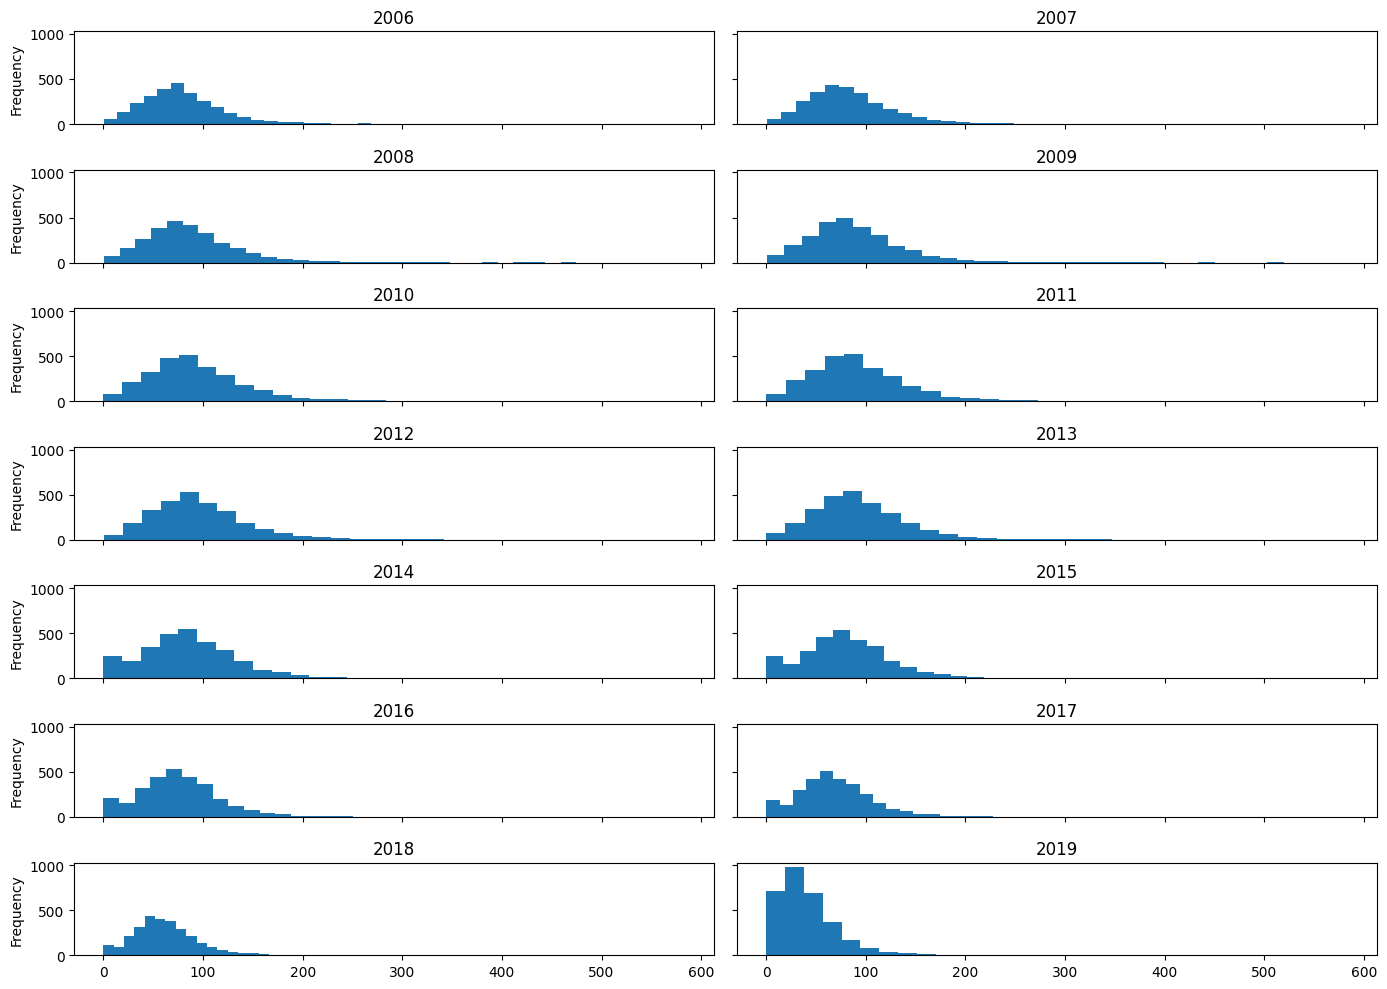

In [8]:
(
    df[["Opioid Dispensing Rate per 100", "year"]].plot.hist(
        by="year",
        figsize=(14, 10),
        layout=(7, 2),
        sharex=True,
        sharey=True,
        legend=False,
        bins=30,
    )
)

plt.tight_layout()

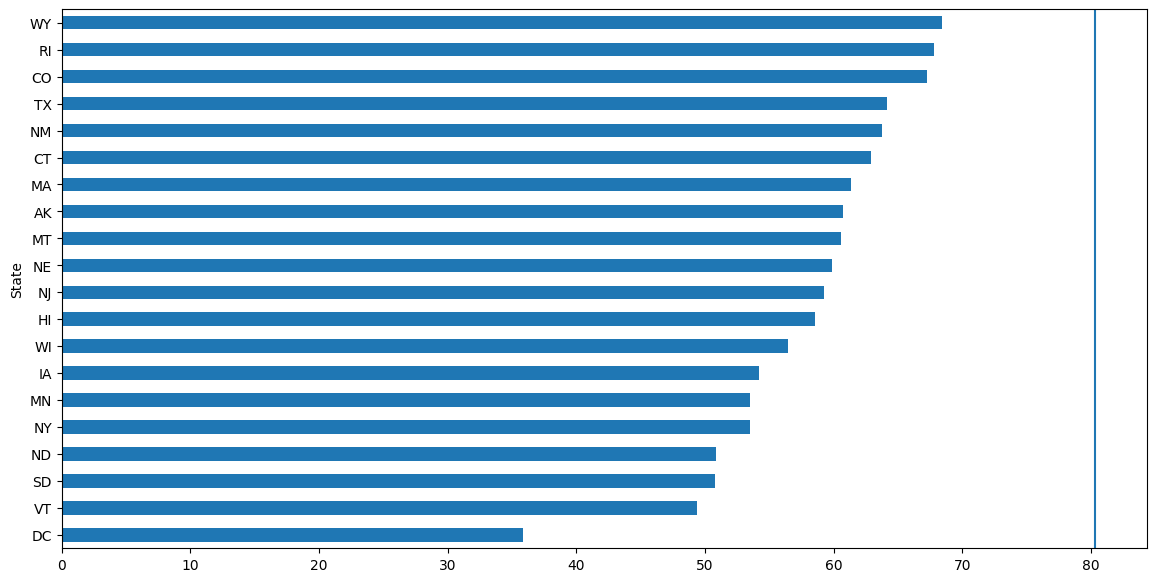

In [9]:
plt.figure(figsize=(14, 7))

(
    df
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .mean()
    .sort_values()
    .head(20)
    .plot.barh()
)

plt.axvline(x=df['Opioid Dispensing Rate per 100'].mean())

In [ ]:
(
    df
    .groupby("year")["Opioid Dispensing Rate per 100"]
    .mean()
    .plot.line()
)

plt.title("Opioid dispensing rate per 100 (2006-2019)")

In [12]:
trydf = df.copy()
geo_df = gpd.read_file("./data/cb_2022_us_county_500k/cb_2022_us_county_500k.shp")
# trydf = trydf.query("year == 2019")
trydf = trydf.rename(columns={"County FIPS Code": "GEOID"})
trydf["GEOID"] = trydf["GEOID"].astype("str")
geo_df["GEOID"] = geo_df["GEOID"].str.lstrip("0")
geo_df["GEOID"] = geo_df["GEOID"].astype("str")
trydf["year"] = trydf["year"].astype("int")

In [13]:
gdf = geo_df.merge(trydf, how="left", on="GEOID").drop(
    columns=[
        "STATEFP",
        "COUNTYFP",
        "COUNTYNS",
        "AFFGEOID",
        "LSAD",
        "ALAND",
        "AWATER",
        "Unnamed: 0",
    ]
)

In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = gdf["Opioid Dispensing Rate per 100"].min()
vmax = gdf["Opioid Dispensing Rate per 100"].max()

plot_extra = True
for i in range(2006, 2020):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    gdf[~(gdf["State"].isin(["AK", "HI"])) & (gdf["year"] == i)].to_crs(
        epsg=2163
    ).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        legend=True,
        ax=ax,
        legend_kwds={"label": "Opioid Dispensing Rate per 100", "shrink": 0.7},
        edgecolor="k",
        vmin=vmin,
        vmax=vmax
    )
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.3])
    gdf[(gdf["State"] == "AK") & (gdf["year"] == i)].to_crs(epsg=3338).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_ak,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.43, 0.05, 0.2, 0.3])
    gdf[(gdf["State"] == "HI") & (gdf["year"] == i)].to_crs(epsg=4326).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_hi,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df = (
            gdf.groupby("year")["Opioid Dispensing Rate per 100"].mean().reset_index()
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        gdf[gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=30
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)

In [479]:
# cleanup workspace (don't run if still working!)
import sys
sys.modules[__name__].__dict__.clear()

# References

1. https://stackoverflow.com/questions/55767312/how-to-position-suptitle
2. https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size
3. https://geopandas.org/en/stable/docs/user_guide/missing_empty.html
4. 